In [1]:
from Plain import Dissertation_Plain_1D

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model = Dissertation_Plain_1D(
    L=1500, N=150001, T=1500, dt=0.1, k=0.01, m0=0.5,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=1000, t_end=1490, num_points=600
)
model.solve()


: 

: 

❌ Not enough valid front points.


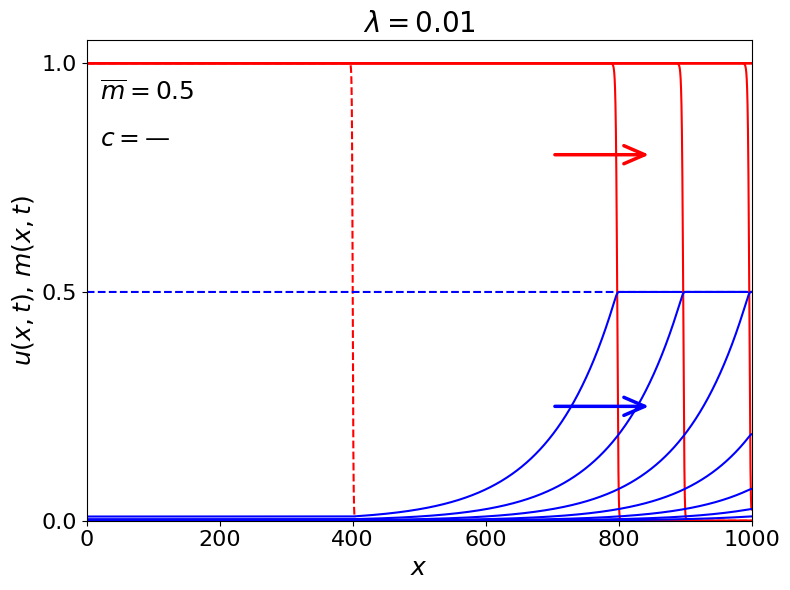

In [ ]:
model.plot_u_m_with_custom_style(
    [0,  400, 500 , 600, 700, 800, 900, 1000],
    show_arrows=True,
    show_speed_text=True,
    print_speed=True,          # also prints c in console/logs
    head_length=1.5, head_width=0.65)

In [15]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

# ---------- Model kernels ----------
@njit
def f_numba(N, rho, K):
    # tumour growth: N_t = rho * N * (1 - N/K)
    return rho * N * (1 - N / K)

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    """
    Variable-coefficient diffusion with edge-averaged M:
    (D * M*(1-M) * u_x)_x  with homogeneous Neumann BCs.
    Returns three diagonals (lower, center, upper) scaled by 1/dx^2.
    """
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = - (Dl + Dr)

    # Neumann BC at x=0
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0]  =  2 * Dr

    # Neumann BC at x=L
    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1]  =  2 * Dl

    invdx2 = 1.0 / dx**2
    return invdx2 * lower, invdx2 * center, invdx2 * upper

# ---------- Main class ----------
class Dissertation_Plain_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200):
        # PDE/ODE params
        self.D = D; self.rho = rho; self.K = K
        self.k = k; self.n0 = n0; self.m0 = m0
        self.Mmax = Mmax; self.perc = perc
        self.steepness = steepness

        # grid/time
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt
        # number of *time levels* we will march to: i = 0..Nt-1; time = i*dt; last time ~ (Nt-1)*dt ≈ T
        self.Nt = int(np.floor(T / dt)) + 1
        self.scheme = scheme.upper()
        self.init_type = init_type

        # storage placeholders (filled in solve)
        self.times = None
        self.N_arr = None
        self.M_arr = None
        self.wave_speed = None

        # wave speed tracking params
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    # ----- ICs -----
    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    # ----- Diffusion operator -----
    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], offsets=[-1, 0, 1], format="csr")

    # ----- Time stepping with strided storage -----
    def solve(self, save_stride=2):
        """
        N: AB2–AM2 (IMEX)
        M: implicit Euler exact form for dm/dt = -k*N*m with N taken at t^{n+1}:
           M^{n+1} = M^n / (1 + k*dt*N^{n+1})

        save_stride: only store every k-th time level (always includes t=0 and final time).
        """
        if save_stride < 1:
            raise ValueError("save_stride must be >= 1")

        # precompute which time indices to save (booleans of length Nt)
        save_mask = np.zeros(self.Nt, dtype=bool)
        save_mask[0] = True
        save_mask[1::save_stride] = True
        save_mask[-1] = True  # ensure we keep the final frame

        n_save = int(save_mask.sum())
        self.N_arr = np.zeros((n_save, self.N))
        self.M_arr = np.zeros((n_save, self.N))
        full_times = np.arange(self.Nt) * self.dt
        self.times = full_times[save_mask]

        # initial data (time index i=0)
        N_prev, M_prev = self.initial_condition()
        f_prev = f_numba(N_prev, self.rho, self.K)
        L_prev = self.update_laplacian(M_prev)

        # store i=0 if requested
        save_idx = 0
        if save_mask[0]:
            self.N_arr[save_idx] = N_prev
            self.M_arr[save_idx] = M_prev
            save_idx += 1

        # first step to i=1: implicit Euler for N using M_prev
        A0 = (eye(self.N, format="csr") - self.dt * L_prev)
        N_curr = spsolve(A0.tocsc(), N_prev + self.dt * f_prev)

        # M update at i=1 using N_curr
        denom = 1.0 + self.k * self.dt * np.maximum(N_curr, 0.0)
        M_curr = M_prev / denom
        np.clip(M_curr, 0.0, self.Mmax, out=M_curr)

        if self.Nt > 1 and save_mask[1]:
            self.N_arr[save_idx] = N_curr
            self.M_arr[save_idx] = M_curr
            save_idx += 1

        # main loop for i = 2..Nt-1
        for i in range(2, self.Nt):
            # assemble with current M for N's diffusion
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)

            # AB2–AM2 for N
            I = eye(self.N, format="csr")
            rhs = (I + 0.5 * self.dt * L_prev) @ N_curr + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (I - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)

            # Enforce Neumann ends by copying interior neighbors
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            # implicit Euler for M with N_next
            denom = 1.0 + self.k * self.dt * np.maximum(N_next, 0.0)
            M_next = M_curr / denom
            np.clip(M_next, 0.0, self.Mmax, out=M_next)

            # store only if requested
            if save_mask[i]:
                self.N_arr[save_idx] = N_next
                self.M_arr[save_idx] = M_next
                save_idx += 1

            # roll
            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev = f_curr
            L_prev = L_curr

    # ----- Front tracking -----
    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x, y):
            if method == 'cubic': return CubicSpline(x, y)
            if method == 'pchip': return PchipInterpolator(x, y)
            if method == 'akima': return Akima1DInterpolator(x, y)
            if method == 'linear': return interp1d(x, y, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            sort_idx = np.argsort(x_local)
            x_local, u_local = x_local[sort_idx], u_local[sort_idx]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda xv: float(spline(xv) - threshold), bracket=[x_left, x_right])
                if sol.converged:
                    x_star = sol.root
                    x_fronts.append(x_star)
                    t_fronts.append(t_target)
            except Exception:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9),
                            spline_type='cubic', plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None

        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)

        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t")
            plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()

        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2

    # ----- Pretty plot for u & m -----
    def plot_u_m_with_custom_style(self, t_indices=None,
                                   arrow_len=None, arrow_lw=2.5,
                                   arrow_start_frac=0.5,
                                   head_length=6, head_width=3,
                                   bottom_y=0.2):
        """
        t_indices are indices into the *saved* arrays (respecting save_stride).
        If None, pick a few spread-out frames automatically.
        """
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
        n_saved = len(t_vec)

        if t_indices is None:
            # choose up to 6 roughly equally spaced frames across saved data
            count = min(6, n_saved)
            t_indices = np.linspace(0, n_saved - 1, count, dtype=int)

        # Ensure wave speed is available
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )

        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L  # default 15% of domain

        arrow_x_start = np.clip(arrow_start_frac * self.L, 0.0, self.L)
        arrow_x_end   = np.clip(arrow_x_start + arrow_len, 0.0, self.L)
        if arrow_x_end <= arrow_x_start:
            arrow_x_start = np.clip(self.L - arrow_len, 0.0, self.L)
            arrow_x_end   = self.L

        plt.figure(figsize=(8, 6))

        # Plot profiles (dashed for first saved frame)
        first_idx = t_indices[0]
        for tidx in t_indices:
            t_label = t_vec[tidx]
            ls = '--' if tidx == first_idx else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label:.0f})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label:.0f})$")

        # Arrow styles
        arrow_style_red  = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='red',  lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)

        # Draw arrows
        plt.annotate('', xy=(arrow_x_end, 0.9),      xytext=(arrow_x_start, 0.9),      arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end, bottom_y), xytext=(arrow_x_start, bottom_y), arrowprops=arrow_style_blue)

        # Left-side text
        x_text = x[0] + 0.02 * self.L
        c_str = f"{self.wave_speed:.3g}" if self.wave_speed is not None else "—"
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')

        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()

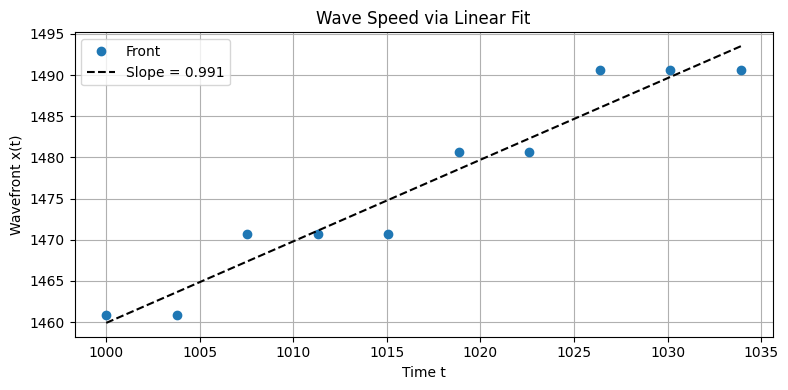

Estimated speed = 0.9908, R² = 0.9394
Estimated speed = 0.9908, R² = 0.9394


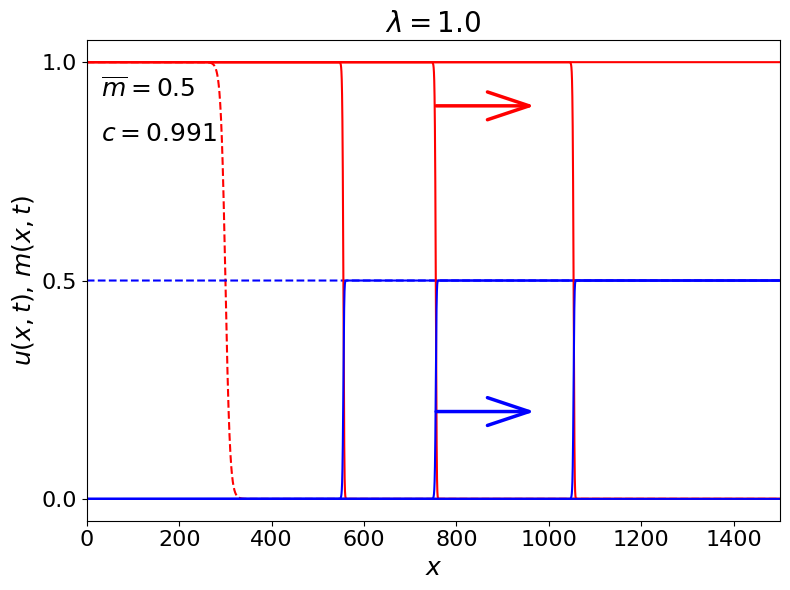

In [7]:
# Instantiate your model
model = Dissertation_Plain_1D(
    D=1.0, rho=1.0, K=1.0, k=1.0,
    n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
    L=1500.0, N=150001, T=1800.0, dt=0.1,
    scheme="AB2AM2", init_type="tanh", steepness=0.1,
    t_start=1000.0, t_end=1750.0, num_points=200
)

# Run solver, saving every 100th step
model.solve(save_stride=100)

# Estimate speed
speed, intercept, r2 = model.estimate_wave_speed(
    threshold=0.5, band=(0.1, 0.9),
    spline_type='cubic', plot=True, target='N'
)

# Plot some profiles
model.plot_u_m_with_custom_style(
    t_indices=[0, 10, 30, 60, -1],   # indices into the *saved* snapshots
    head_length=3, head_width=1
)

Chosen saved times: [500.1 700.1 800.1 900.1]


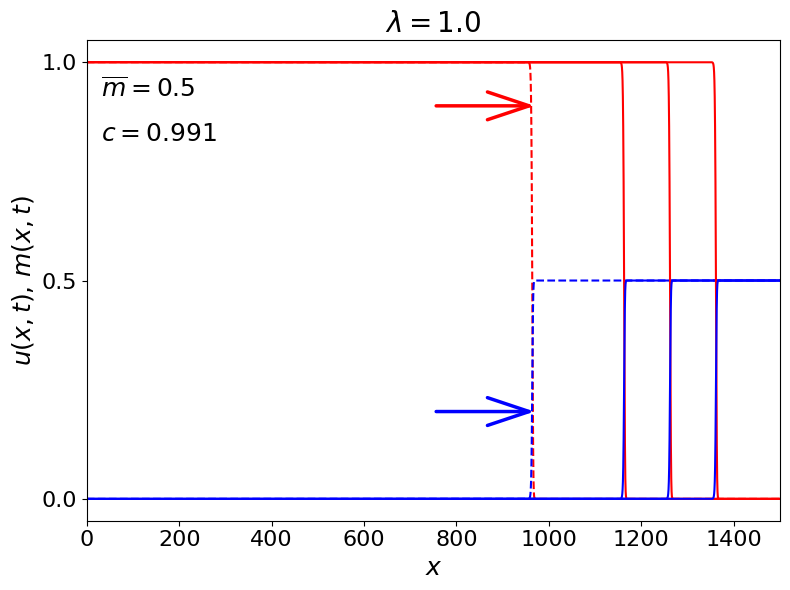

In [11]:
# times you want (in original physical time)
t_wanted = [500,700, 800, 900]

# map to nearest saved indices (works regardless of how you built the save mask)
t_indices = [int(np.argmin(np.abs(model.times - t))) for t in t_wanted]

print("Chosen saved times:", model.times[t_indices])  # sanity check

# plot
model.plot_u_m_with_custom_style(
    t_indices=t_indices,
    head_length=3, head_width=1
)

In [18]:
# ==== Imports ====
import os, json
from pathlib import Path
import numpy as np
from joblib import Parallel, delayed

# IMPORTANT: import the Plain model (no alpha term)

# -------------------------
# Save / path helpers
# -------------------------
def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def _atomic_write_json(path: Path, obj):
    tmp = path.with_suffix(".tmp")
    with open(tmp, "w") as f:
        json.dump(obj, f, indent=2)
    os.replace(tmp, path)

def _save_summary(run_dir: Path, meta: dict):
    with open(run_dir / "summary.json", "w") as f:
        json.dump(meta, f, indent=2)

def _save_fronts(run_dir: Path, t_fronts, x_fronts, name=None):
    fname = "fronts.npz" if not name else f"fronts_{name}.npz"
    np.savez_compressed(run_dir / fname,
                        t_fronts=np.asarray(t_fronts),
                        x_fronts=np.asarray(x_fronts))

def _save_snapshots_plain(run_dir: Path, model):
    """
    For the Plain model, arrays are ALREADY strided by save_stride in model.solve().
    Just save what the model currently holds.
    """
    np.savez_compressed(
        run_dir / "snapshots.npz",
        x=model.x,
        times=model.times,     # these are the saved times
        N_arr=model.N_arr,     # tumour u(x,t) at saved times
        M_arr=model.M_arr      # ECM   m(x,t) at saved times
    )

def _fmt_val(v):
    if isinstance(v, (int, np.integer)) or (isinstance(v, float) and v.is_integer()):
        return f"{int(v)}"
    s = f"{v}"
    return s.rstrip('0').rstrip('.') if '.' in s else s

# -------------------------
# Single-run worker (Plain model)
# -------------------------
def run_one_plain(lam, m0,
                  base_dir="speeds_plain",
                  model_kwargs=None,
                  overwrite=False,
                  save_stride=100):
    """
    Builds, solves (with strided storage), measures, and saves one (λ, m0) run.
    Saves:
      - summary.json (metadata + wave speed + R^2)
      - fronts.npz    (t_fronts, x_fronts for N at threshold 0.5)
      - snapshots.npz (x, times, N_arr, M_arr) from the model's own strided storage
    """
    if model_kwargs is None:
        model_kwargs = {}

    try:
        local_kwargs = dict(model_kwargs)

        base = Path(base_dir)
        lam_dir = base / f"lambda_{_fmt_val(lam)}"
        run_dir = lam_dir / f"m0_{_fmt_val(m0)}"
        _ensure_dir(run_dir)

        if not overwrite and (run_dir / "summary.json").exists():
            return ("skipped", lam, m0)

        # Keep BLAS threads from oversubscribing
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
        os.environ.setdefault("MKL_NUM_THREADS", "1")
        os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

        # Build + solve (note: Plain model has no 'alpha')
        model = Dissertation_Plain_1D(k=lam, m0=m0, **local_kwargs)
        model.solve(save_stride=save_stride)

        # Estimate wave speed on u (N)
        c, b, r2 = model.estimate_wave_speed(
            threshold=0.5, band=(0.1, 0.9), spline_type='cubic',
            plot=False, target='N'
        )
        if (c is None) or not np.isfinite(c):
            raise ValueError("Wave speed not available.")
        model.wave_speed = c

        # Front points (N)
        t_fronts, x_fronts = model.track_wavefront_local_interpolation(
            threshold=0.5, band=(0.1, 0.9), spline_type='cubic', target='N'
        )

        # Save artifacts
        _save_summary(run_dir, dict(
            lambda_val=float(lam),
            m0=float(m0),
            wave_speed=float(c),
            r2=(float(r2) if r2 is not None else None),
            # useful context
            dt=model.dt, T=model.T, L=model.L, N=model.N,
            init_type=model.init_type,
            steepness=getattr(model, "steepness", None),
            perc=getattr(model, "perc", None),
            t_start=model.t_start, t_end=model.t_end,
            num_points=getattr(model, "num_points", None),
            saved_stride=int(save_stride)
        ))
        _save_fronts(run_dir, t_fronts, x_fronts, name="N")
        _save_snapshots_plain(run_dir, model)

        return ("done", lam, m0, float(c), (float(r2) if r2 is not None else None))

    except Exception as e:
        return ("failed", lam, m0, str(e))

# -------------------------
# Parallel grid runner (Plain model)
# -------------------------
def run_grid_plain(lambda_vals, m0_vals,
                   base_dir="speeds_plain",
                   model_kwargs=None,
                   overwrite=False,
                   save_stride=100,
                   n_jobs=-1, verbose=10):
    tasks = [(lam, m0) for lam in lambda_vals for m0 in m0_vals]
    results = Parallel(n_jobs=n_jobs, verbose=verbose, backend="loky")(
        delayed(run_one_plain)(
            lam, m0,
            base_dir=base_dir,
            model_kwargs=model_kwargs,
            overwrite=overwrite,
            save_stride=save_stride
        ) for lam, m0 in tasks
    )

    done, skipped, failed = [], [], []
    for r in results:
        tag = r[0]
        if tag == "done":
            _, lam, m0, c, r2 = r
            done.append({"lambda": lam, "m0": m0, "c": c, "r2": r2})
        elif tag == "skipped":
            _, lam, m0 = r
            skipped.append({"lambda": lam, "m0": m0})
        elif tag == "failed":
            _, lam, m0, msg = r
            failed.append({"lambda": lam, "m0": m0, "error": msg})

    base = Path(base_dir); _ensure_dir(base)
    _atomic_write_json(base / "failed_runs.json", failed)

    print(f"✅ Done: {len(done)}, Skipped: {len(skipped)}, Failed: {len(failed)}")
    if failed:
        print("❌ Failed runs (sample):")
        for item in failed[:20]:
            print(f"  λ={item['lambda']}, m0={item['m0']} | error: {item['error']}")
    return {"done": done, "skipped": skipped, "failed": failed}

# -------------------------
# Example usage
# -------------------------
lambda_vals = [1e-3, 1e-2, 1e-1]
m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]

shared_kwargs = dict(
    # Heavy but consistent with your big domain/time
    L=2500, N=250001, T=2500, dt=0.1,
    init_type="tanh", steepness=0.1, perc=0.2,
    t_start=1000, t_end=2470, num_points=500,
    n0=1.0, K=1.0, rho=1.0, D=1.0, Mmax=1.0
)

results = run_grid_plain(
    lambda_vals, m0_vals,
    base_dir="speeds_plain",
    model_kwargs=shared_kwargs,
    save_stride=200,     # you said you store every 100 steps
    overwrite=False,
    n_jobs=3, verbose=10
)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    3.1s


❌ Not enough valid front points.
Estimated speed = 0.9942, R² = 0.9995
Estimated speed = 0.9740, R² = 0.9995


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 78.7min


Estimated speed = 0.9740, R² = 0.9995
Estimated speed = 0.9110, R² = 0.9996
Estimated speed = 0.7952, R² = 0.9998
Estimated speed = 0.5964, R² = 0.9998
Estimated speed = 0.4333, R² = 0.9998


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 557.7min


Estimated speed = 0.1979, R² = 0.9998
❌ Not enough valid front points.
Estimated speed = 0.0162, R² = 0.9998
Estimated speed = 0.1979, R² = 0.9998
Estimated speed = 0.4333, R² = 0.9998
Estimated speed = 0.5964, R² = 0.9998


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 1895.4min


Estimated speed = 0.7952, R² = 0.9998
Estimated speed = 0.9110, R² = 0.9996
Estimated speed = 0.9740, R² = 0.9995
Estimated speed = 0.9942, R² = 0.9995
Estimated speed = 0.9740, R² = 0.9995
Estimated speed = 0.9110, R² = 0.9996
Estimated speed = 0.7952, R² = 0.9998


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 2067.3min


Estimated speed = 0.5964, R² = 0.9998
Estimated speed = 0.4333, R² = 0.9998
Estimated speed = 0.1979, R² = 0.9998
Estimated speed = 0.0400, R² = 0.9998
❌ Not enough valid front points.
Estimated speed = 0.1979, R² = 0.9998


KeyboardInterrupt: 

In [12]:
2500/25000

0.1